In [1]:
import os
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

plt.rcParams['figure.figsize'] = (9, 7)

import psycopg2

import pandas as pd

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

%config IPCompleter.greedy = True
%config Completer.use_jedi = False

In [2]:
from pfs.utils.coordinates.transform import ASRDM71Transform, PfiTransform

In [3]:
import lsst.afw.image as afwImage
import lsst.afw.detection as afwDetect
import lsst.afw.display as afwDisplay

In [4]:
afwDisplay.setDefaultBackend("matplotlib")

In [5]:
def frameId(visitId, subVisitId=0):
    """Return a frameId given an visitId and optionally a subVisitId"""
    return "%06d%02d" % (visitId, subVisitId)

def getPFSC(dataId=None, date=None, visit=None, subVisit=None, threshold=None, getFileName=False, saturation=4096):
    """Return an MCS image"""
    if dataId is None:
        dataId = {}

    if date is None:
        date = dataId["date"]
    if visit is None:
        visit = dataId["visit"]
    if subVisit is None:
        subVisit = dataId["subVisit"]

    if date < "2019-08-31":
        root = f"/data/mcs/{date}"
    else:
        root = f"/data_raw/{date}/mcs"

    fileName = os.path.join(root, f"PFSC{frameId(visit, subVisit)}.fits")

    if getFileName:
        return fileName

    pfsc = afwImage.ImageF(fileName)
    pfsc = afwImage.makeMaskedImage(pfsc)

    if threshold is None:
        footprints = []
    else:
        nSat = len(afwDetect.FootprintSet(pfsc, afwDetect.Threshold(saturation), "SAT").getFootprints())
        if nSat > 0:
            print(f"{nSat} saturated spots")

        threshold += np.median(pfsc.image.array)
        footprints = afwDetect.FootprintSet(pfsc, afwDetect.Threshold(threshold), "DETECTED").getFootprints()
    
    return pfsc, footprints

def getMcsData(dataId):
    with conn:
        mcs_data = pd.read_sql(f'''
            SELECT DISTINCT 
                spot_id, mcs_center_x_pix, mcs_center_y_pix
            FROM mcs_data
            WHERE
              mcs_frame_id = {frameId(dataId["visit"], dataId["subVisit"])}
            -- limit 10
            ''', conn)
        
    return mcs_data

In [6]:
# See ~/pgpass
#   *:*:opdb:pfs:XXXX

conn = psycopg2.connect("dbname='opdb' host='pfsa-db01' port=5432 user='pfs'") 

#conn = psycopg2.connect("dbname='opdb' host='133.40.160.36' port=5432 user='pfs'") 

In [7]:
from pfs.utils.butler import Butler

butler = Butler(configRoot=os.path.join(os.environ["PFS_INSTDATA_DIR"], "data"))

# Read fiducial and spot geometry
fids = butler.get('fiducials')

dots = butler.get('black_dots')

In [8]:
if True:
    dataId=dict(date="2021-09-19", visit=67962, subVisit=0)    
else:  # ask opdb for most recent exposure
    with conn:
        tmp = pd.read_sql(f'SELECT mcs_frame_id FROM mcs_data ORDER BY mcs_frame_id DESC LIMIT 1;', conn)
    frame_id = int(tmp.mcs_frame_id[0])

    visit = frame_id//100
    subVisit = frame_id%100
    
    dataId.update(visit=visit, subVisit=subVisit)

    with conn:
        t = pd.read_sql(f'SELECT taken_at, taken_in_hst_at FROM mcs_exposure WHERE mcs_frame_id = {frameId(dataId["visit"], dataId["subVisit"])};', conn)
        t = t.taken_in_hst_at[0]  # !!
    dataId.update(date=f"{t.year}-{t.month:02}-{t.day:02}")

#print("Reading %(visit)d:%(subVisit)d" % dataId)

raw = getPFSC(dataId)[0]

mcs_data = getMcsData(dataId)

with conn:
    tmp = pd.read_sql(f'SELECT insrot, altitude FROM mcs_exposure where pfs_visit_id = {dataId["visit"]};', conn)
altitude, insrot = tmp.altitude[0], tmp.insrot[0]
#
# Get the transform between PFI and MCP coordinates, then transform fiducials/dots to MCS coords
#
pt = PfiTransform(altitude=altitude, insrot=insrot)
pt.updateTransform(mcs_data, fids)

x_fid, y_fid = pt.pfiToMcs(fids.x_mm, fids.y_mm)

x_dot, y_dot = pt.pfiToMcs(dots.x, dots.y)
x, y = pt.pfiToMcs(dots.x + dots.r, dots.y)
r_dot = np.hypot(x - x_dot, y - y_dot)

<IPython.core.display.Javascript object>


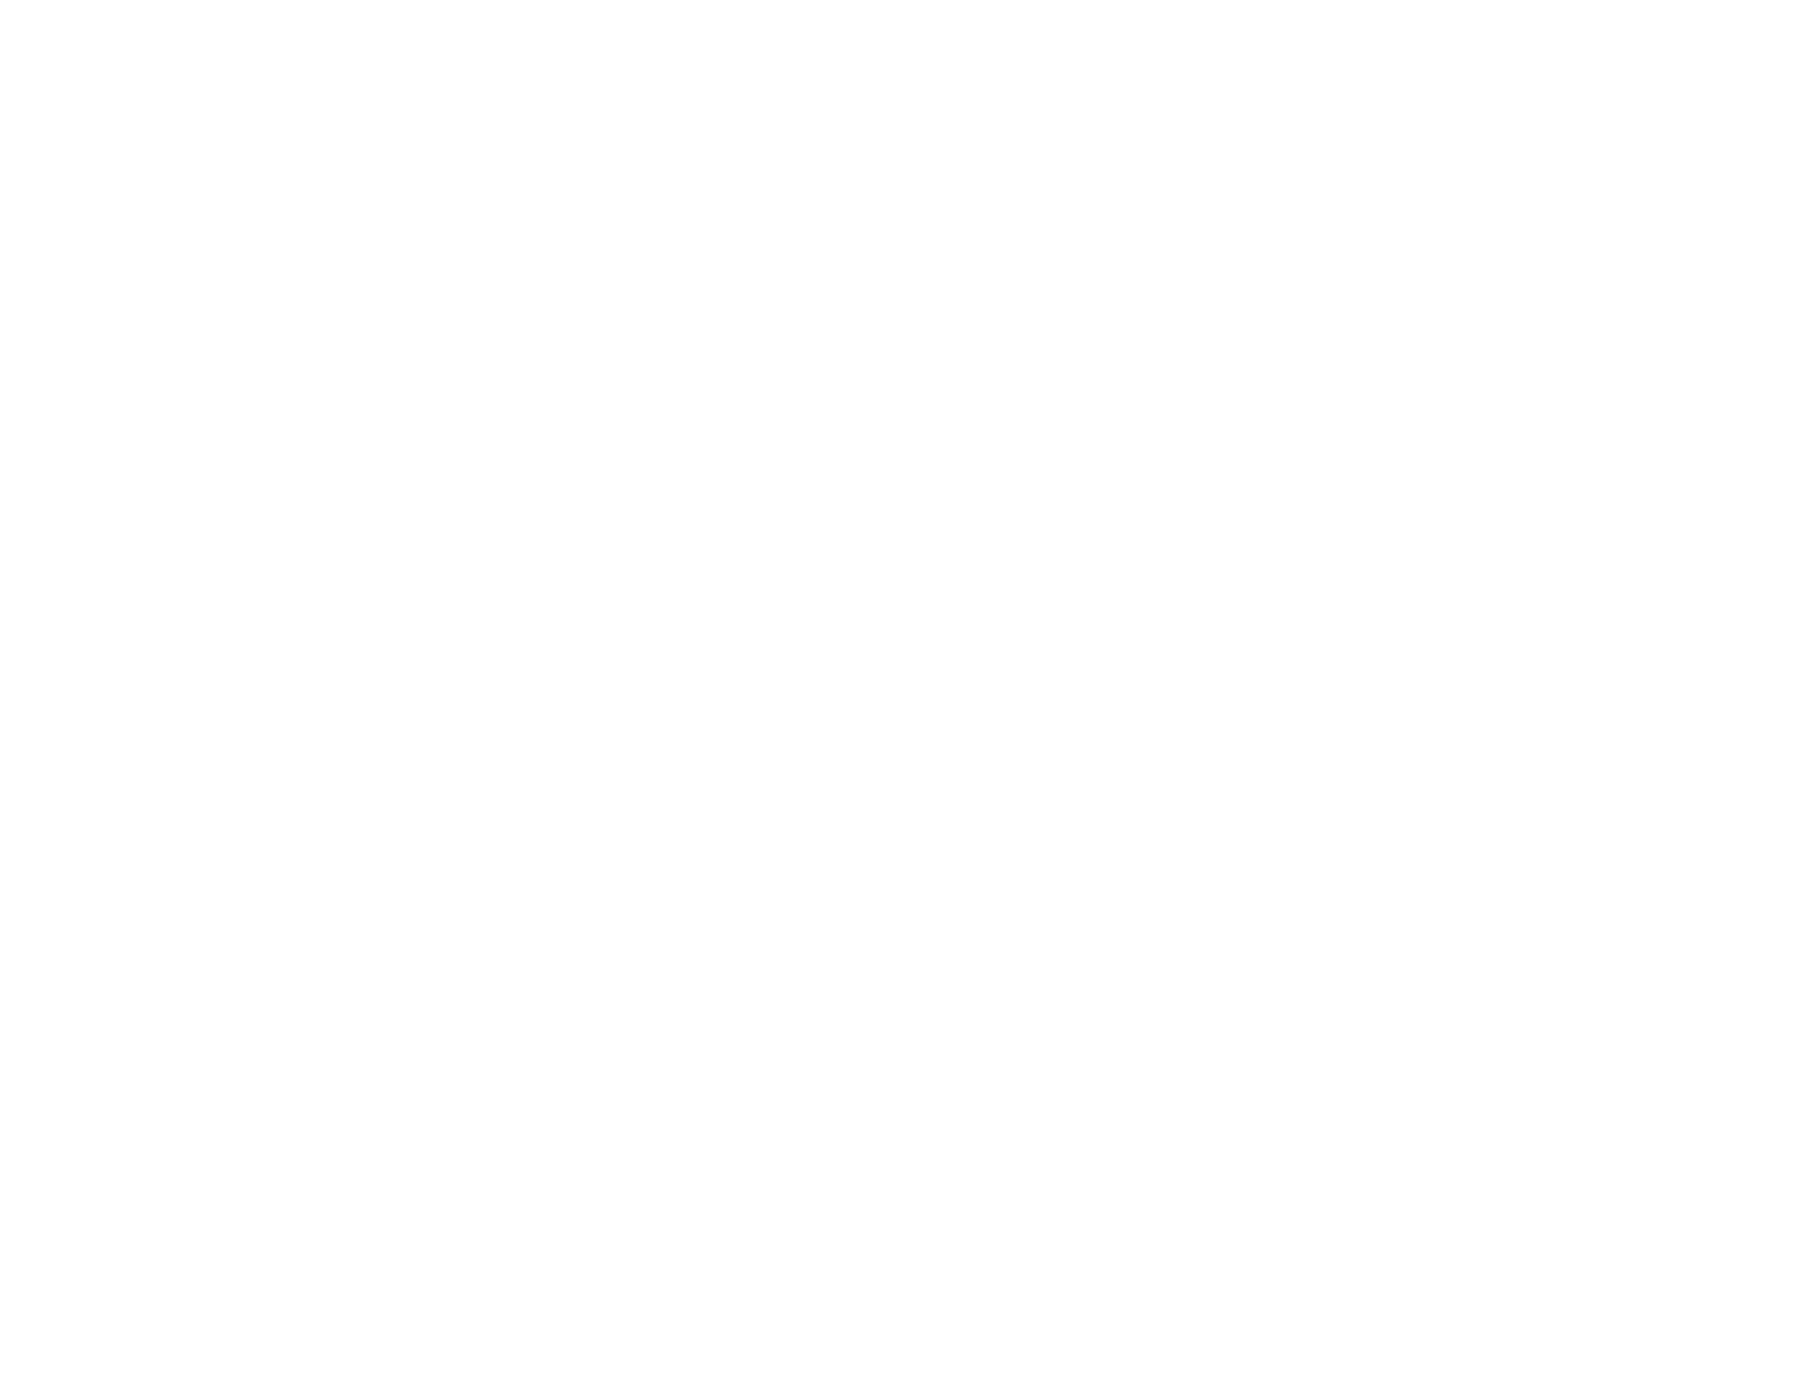

In [9]:
fig = 5; plt.close(fig); fig = plt.figure(fig)
disp = afwDisplay.Display(fig, reopenPlot=False)

disp.scale('asinh', 'zscale')

disp.setMaskPlaneColor("DETECTED", "IGNORE")
disp.setMaskPlaneColor("SAT", "IGNORE")

disp.mtv(raw, title=f"{'date=%(date)s visit=%(visit)d subVisit=%(subVisit)d' % dataId}")
#
# Show detected dots
#
plt.plot(mcs_data.mcs_center_x_pix, mcs_data.mcs_center_y_pix, '.', alpha=0.5)
#
# And nominal positions of fiducials
#
plt.plot(x_fid, y_fid, '+', color='blue')
#
# And nominal positions of black dots
#
ax = plt.gca()
for x, y, r in zip(x_dot, y_dot, r_dot):
    c = Circle((x, y), r, color='red', alpha=0.3)
    ax.add_patch(c)

In [10]:
#
# We don't have a fiducial fibre image at the same insrot and taken around the same time as 67472, 
# so process the data ourselves to generate the "mcs_data.mcs_center_[xy]_pix" arrays
#
dataId=dict(date="2021-09-16", visit=67472, subVisit=0)  # rotation tests 

raw, fs = getPFSC(dataId, threshold=6000)

with conn:
    tmp = pd.read_sql(f'SELECT insrot, altitude FROM mcs_exposure where pfs_visit_id = {dataId["visit"]};', conn)
altitude, insrot = tmp.altitude[0], tmp.insrot[0]

x = np.empty(len(fs))
y = np.empty_like(x)

for i, foot in enumerate(fs):
    x[i], y[i] = foot.getCentroid()
    
mcs_data = pd.DataFrame(dict(mcs_center_x_pix=x, mcs_center_y_pix=y))
#
# And build the PfiTransform
#
pt = PfiTransform(altitude=altitude, insrot=insrot)
pt.updateTransform(mcs_data, fids)

1 saturated spots


In [11]:
#
# Show an MCS image when we have the dome lights on to show PFI structures
#
from lsst.meas.algorithms import SubtractBackgroundTask

config = SubtractBackgroundTask.ConfigClass()
config.binSize = 64
backgroundTask = SubtractBackgroundTask(config=config)
#
# Specify data and read it
#
dataId=dict(date="2021-09-16", visit=67472, subVisit=0)

raw = getPFSC(dataId)[0]

# subtract an estimate of the background
backgroundTask.run(afwImage.makeExposure(raw))
# and the median column to get rid of some of the bias striping
raw.image.array -= np.median(raw.image.array, axis=0)
#
# Display time
#
fig = 1; plt.close(fig); fig = plt.figure(fig)
disp = afwDisplay.Display(fig, reopenPlot=False)

disp.scale('asinh', 0, 40, Q=2)

disp.setMaskPlaneColor("DETECTED", "IGNORE")
disp.setMaskPlaneColor("SAT", "IGNORE")
#
# Transform to MCS coordinates
#
x_dot, y_dot = pt.pfiToMcs(dots.x, dots.y)
x, y = pt.pfiToMcs(dots.x + dots.r, dots.y)
r_dot = np.hypot(x - x_dot, y - y_dot)

x_fid, y_fid = pt.pfiToMcs(fids.x_mm, fids.y_mm)
#
# Choose which part[s] of the PFI we want to display
#
hsize = 150   # half-size of images centered at centers
if False:     # entire field
    hsize = 2700
    centers = [(pt.mcs_boresight_x_pix, pt.mcs_boresight_y_pix)]
elif False:   # Show fiducials
    centers = []
    for fid in [25, 76, 56, 44]:
        l = fiducialId == fid
        centers.append((x_fid[l], y_fid[l]))
else:         # four places symmetrically around the field
    rad = 1600
    centers = [(pt.mcs_boresight_x_pix - rad, pt.mcs_boresight_y_pix + rad), (pt.mcs_boresight_x_pix + rad, pt.mcs_boresight_y_pix + rad),
               (pt.mcs_boresight_x_pix - rad, pt.mcs_boresight_y_pix - rad), (pt.mcs_boresight_x_pix + rad, pt.mcs_boresight_y_pix - rad)]

for i, (cx, cy) in enumerate(centers, 1):
    if len(centers) == 1:
        ax = plt.gca()

    elif len(centers) == 4:
        ax = fig.add_subplot(2, 2, i)
    else:
        raise RuntimeError("I only understand requests for one or four centres; sorry")

    disp.mtv(raw[cx-hsize:cx+hsize+1, cy-hsize:cy+hsize+1])
    if len(centers) > 1:
        disp.show_colorbar(False)

    x, y, r = x_dot, y_dot, r_dot

    ax = plt.gca()
    for x, y, r in zip(x, y, r):
        c = Circle((x, y), r, color='red', alpha=0.3)
        ax.add_patch(c)

    if True:
        plt.plot(x_fid, y_fid, '+', color='blue', alpha=0.6)
    else:
        for x, y, fid in zip(x_fid, y_fid, fiducialId):
            plt.text(x, y, str(fid), color='blue', 
                     horizontalalignment='center', verticalalignment='center')

    plt.xlim(cx-hsize, cx+hsize+1)
    plt.ylim(cy-hsize, cy+hsize+1)

plt.suptitle(f"{'date=%(date)s visit=%(visit)d subVisit=%(subVisit)d' % dataId}", y=0.95);

### Now the ASRD 71M camera

<IPython.core.display.Javascript object>


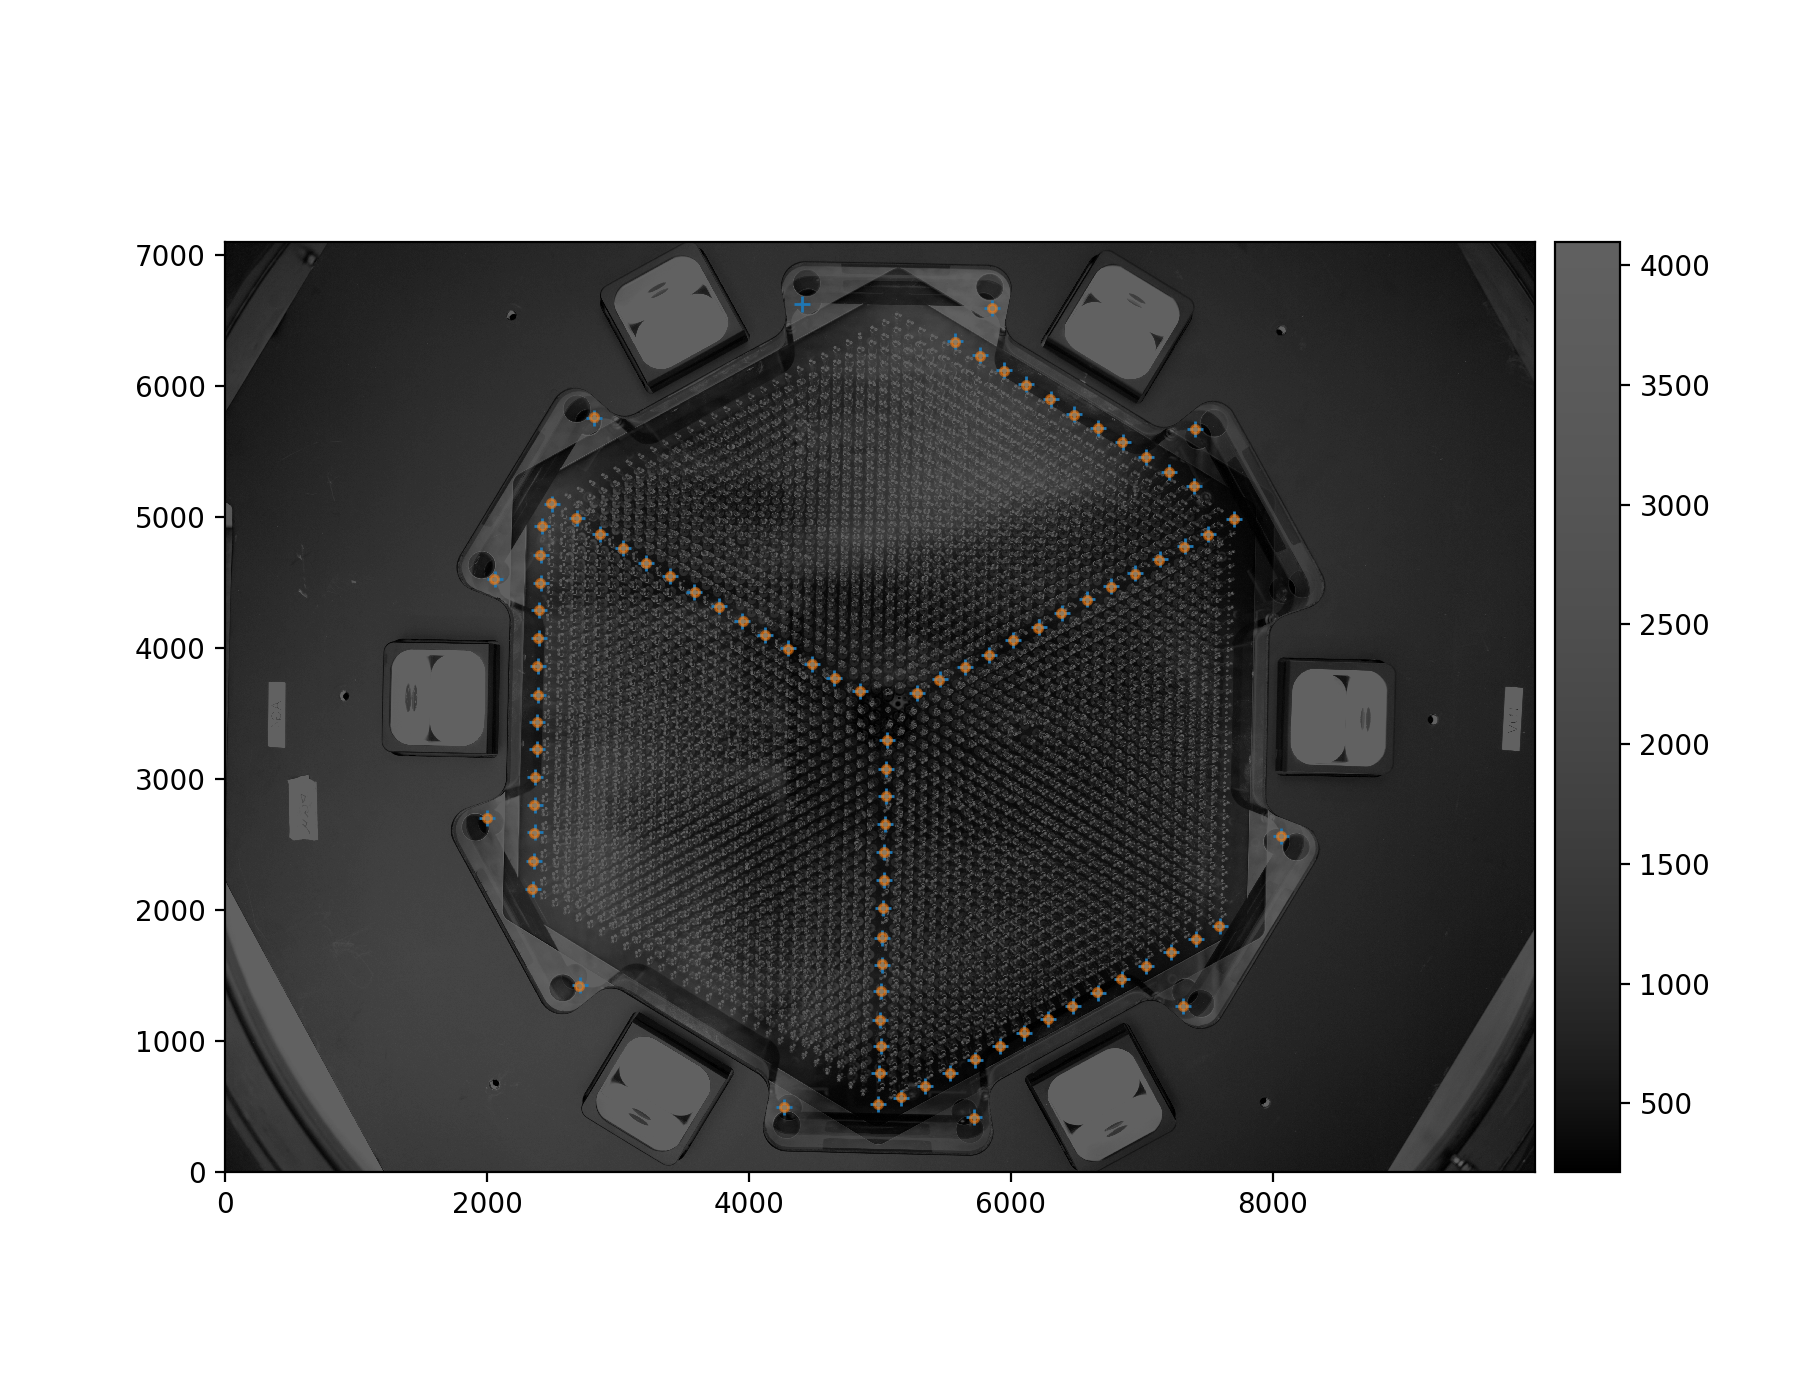

In [16]:
dirName = os.path.join(os.environ["PFS_INSTDATA_DIR"], "data/pfi/dot")

dotDF = pd.read_csv(os.path.join(dirName, "ff_subaru_20210710_el90_rot+00_ave.csv"))
x_fid, y_fid = dotDF.x_pixel, dotDF.y_pixel  # camera pixels

fids = butler.get('fiducials')

mcs_data = pd.DataFrame(dict(mcs_center_x_pix=x_fid, mcs_center_y_pix=y_fid))

pt = ASRDM71Transform()
pt.updateTransform(mcs_data, fids)  # not needed for now

raw = afwImage.ImageF("/home/cloomis/dots-benchcam-subaru/2021-07-10/PFSC22587900.fits")

fig = 5; plt.close(fig); fig = plt.figure(fig)
disp = afwDisplay.Display(5, reopenPlot=False)
disp.scale('asinh', 'zscale')

disp.mtv(raw)

plt.plot(x_fid, y_fid, '+')

x, y = pt.pfiToMcs(fids.x_mm, fids.y_mm)

plt.plot(x, y, '.', alpha=0.5);